In [1]:
import torch
import os
import torchvision
from torchvision.transforms import v2
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
from PIL import Image, ImageOps
import torch
import pdb
import numpy as np
import yaml
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from template import utils
from torchvision.utils import save_image

import torch.nn.functional as F

In [2]:
# setting config
config = yaml.safe_load(open("config.yaml"))
batch_size = int(config["BATCH_SIZE"])

print(f"Our config: {config}")

Our config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    v2.Resize((128,128))
])

In [4]:
train_dataset = torchvision.datasets.CelebA(root='./data', split='train',
                                        download=True, transform=transform)
valid_dataset = torchvision.datasets.CelebA(root='./data', split='valid',
                                       download=True, transform=transform)
test_dataset = torchvision.datasets.CelebA(root='./data', split='test',
                                       download=True, transform=transform)

#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Display images from the dataset

In [5]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

Image Shapes: torch.Size([64, 3, 128, 128])
Label Shapes: torch.Size([64, 40])


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


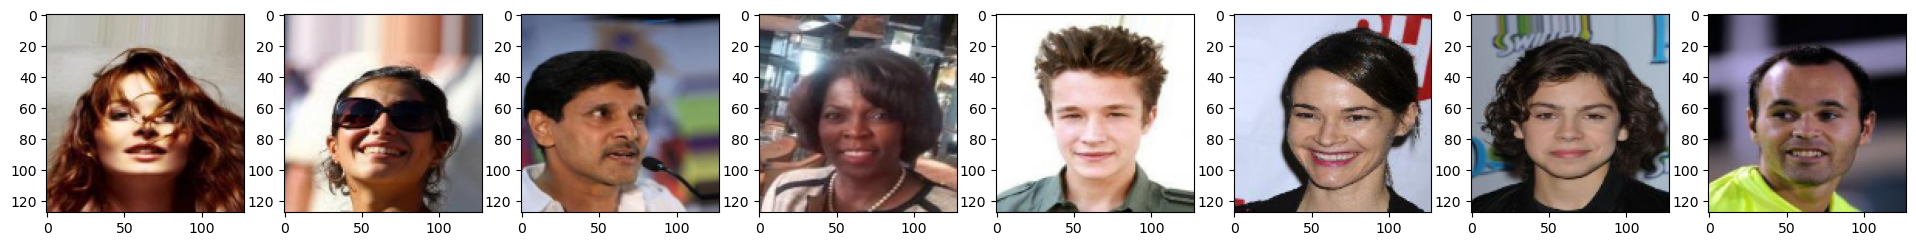

In [6]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(3,128,128).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

In [34]:
def save_model(model, optimizer, epoch, stats, exp_no = 7302): #7300
    """ Saving model checkpoint """
    
    if(not os.path.exists("experiments/experiment_"+str(exp_no)+"/models")):
        os.makedirs("experiments/experiment_"+str(exp_no)+"/models")
    savepath = "experiments/experiment_"+str(exp_no)+f"/models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats

In [37]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device, lambda_kld = 1e-03):
    """ Training a model for one epoch """
    
    loss_list = []
    recons_loss = []
    vae_loss = []
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, _) in progress_bar:
        images = images.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass
        recons, (z, mu, log_var) = model(images)
         
        # Calculate Loss
        loss, (mse, kld) = criterion(recons, images, mu, log_var, lambda_kld)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        vae_loss.append(kld.item())
        
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
        
    mean_loss = np.mean(loss_list)
    
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device, epoch=None, savefig=False, savepath="", writer=None, lambda_kld = 1e-03):
    """ Evaluating the model for either validation or test """
    loss_list = []
    recons_loss = []
    kld_loss = []
    
    for i, (images, _) in enumerate(eval_loader):
        images = images.to(device)
        
        # Forward pass 
        recons, (z, mu, log_var) = model(images)
                 
        loss, (mse, kld) = criterion(recons, images, mu, log_var, lambda_kld)
        loss_list.append(loss.item())
        recons_loss.append(mse.item())
        kld_loss.append(kld.item())
        
        if(i==0 and savefig):
            save_image(recons[:64].cpu(), os.path.join(savepath, f"recons{epoch}.png"))
            
    # Total correct predictions and loss
    loss = np.mean(loss_list)
    recons_loss = np.mean(recons_loss)
    kld_loss = np.mean(kld_loss)
    return loss, recons_loss, kld_loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader,
                num_epochs, writer,savepath="", save_frequency=2,lambda_kld = 1e-03):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    val_loss_recons =  []
    val_loss_kld =  []
    loss_iters = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        log_epoch = (epoch % save_frequency == 0 or epoch == num_epochs - 1)
        loss, recons_loss, kld_loss = eval_model(
                model=model, eval_loader=valid_loader, criterion=criterion,
                device=device, epoch=epoch, savefig=log_epoch, savepath=savepath,
                writer=writer, lambda_kld = lambda_kld
            )
        val_loss.append(loss)
        val_loss_recons.append(recons_loss)
        val_loss_kld.append(kld_loss)

        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device, lambda_kld = lambda_kld 
            )
        
        # PLATEAU SCHEDULER
        scheduler.step(val_loss[-1])
        train_loss.append(mean_loss)
        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % save_frequency == 0):
            stats = {
                "train_loss": train_loss,
                "valid_loss": val_loss,
                "loss_iters": loss_iters
            }
            save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats)
        
        if(log_epoch):
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"       Valid loss recons: {round(val_loss_recons[-1], 5)}")
            print(f"       Valid loss KL-D:   {round(val_loss_kld[-1], 5)}")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld

Dropouts + additional conv layers led to brwon pictures, but more details -> did not improve. When only using kernel size = 2 we saw very blocky pictures so we opted for kernel size 3 with a smaller stride. The results were as expected. We lost some of the blockieness. Increasing encoder linear layers did not help   (led to brownness)

In [ ]:
class ConvVAE(nn.Module):
    
    def __init__(self):
        super(ConvVAE, self).__init__()

        # Define Convolutional Encoders
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels = 8, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Flatten(),
        )

        # Define mean and variance
        self.mu = nn.Linear(8192, 200)
        
        # Note: we learn the log variance to make training easier (allows negative values)
        self.log_var = nn.Linear(8192, 200)

        # Define decoder
        self.decoder = nn.Sequential(
            nn.Linear(200, 8192),
            nn.ReLU(),
            nn.Unflatten(dim = 1, unflattened_size=(32, 16, 16)),
            nn.ConvTranspose2d(in_channels = 32, out_channels=32, kernel_size = 3, stride = 2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels = 16, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 2, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=3, kernel_size=8, stride = 1, padding = 0),
            nn.ReLU()
        )

    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mu(x)
        log_var = self.log_var(x)

        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, (z, mean, log_var)

test = nn.ConvTranspose2d(3, 16, kernel_size = 3, stride = 2, padding = 0)
cvae = ConvVAE()

x = torch.zeros(32, 200)
cvae.decoder(x).shape

In [7]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    """
    Combined loss function for joint optimization of 
    reconstruction and ELBO
    """
    recons_loss = F.mse_loss(recons, target)
    # Deriving kld for vaes: https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)  # closed-form solution of KLD in Gaussian
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cvae = ConvVAE()
criterion = vae_loss_function
optimizer = torch.optim.Adam(cvae.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5, verbose = True)
cvae = cvae.to(device)

In [24]:
savepath = "/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_4"


In [25]:
cvae.load_state_dict(x['model_state_dict'])

RuntimeError: Error(s) in loading state_dict for ConvVAE:
	Unexpected key(s) in state_dict: "encoder.9.weight", "encoder.9.bias". 
	size mismatch for mu.weight: copying a param with shape torch.Size([200, 4096]) from checkpoint, the shape in current model is torch.Size([200, 8192]).
	size mismatch for log_var.weight: copying a param with shape torch.Size([200, 4096]) from checkpoint, the shape in current model is torch.Size([200, 8192]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([4096, 200]) from checkpoint, the shape in current model is torch.Size([8192, 200]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([8192]).
	size mismatch for decoder.3.weight: copying a param with shape torch.Size([64, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([16, 8, 2, 2]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for decoder.9.weight: copying a param with shape torch.Size([8, 3, 2, 2]) from checkpoint, the shape in current model is torch.Size([3, 8, 8, 8]).

In [14]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=cvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=15, savepath=savepath, writer=None)

  0%|          | 0/1272 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [18]:
cvae = load_model(ConvVAE, optimizer=optimizer, savepath = '/home/user/lschulze/projects/CudaVisionWS23/Assignment5/experiments/experiment_1/models/checkpoint_epoch_5.pth')

TypeError: Module.load_state_dict() missing 1 required positional argument: 'state_dict'

In [ ]:
eval_model(cvae, validloader, criterion=criterion, device=device)

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from No

(0.0729166641831398, 0.06857893689029469, 4.337727179481286)

In [ ]:
with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 200).to(device)
        sample = cvae.decoder(z)
    

recons = sample.view(64, 3, 128, 128).cpu()

recons.shape

torch.Size([64, 3, 128, 128])

In [ ]:
recons.shape

torch.Size([64, 3, 128, 128])

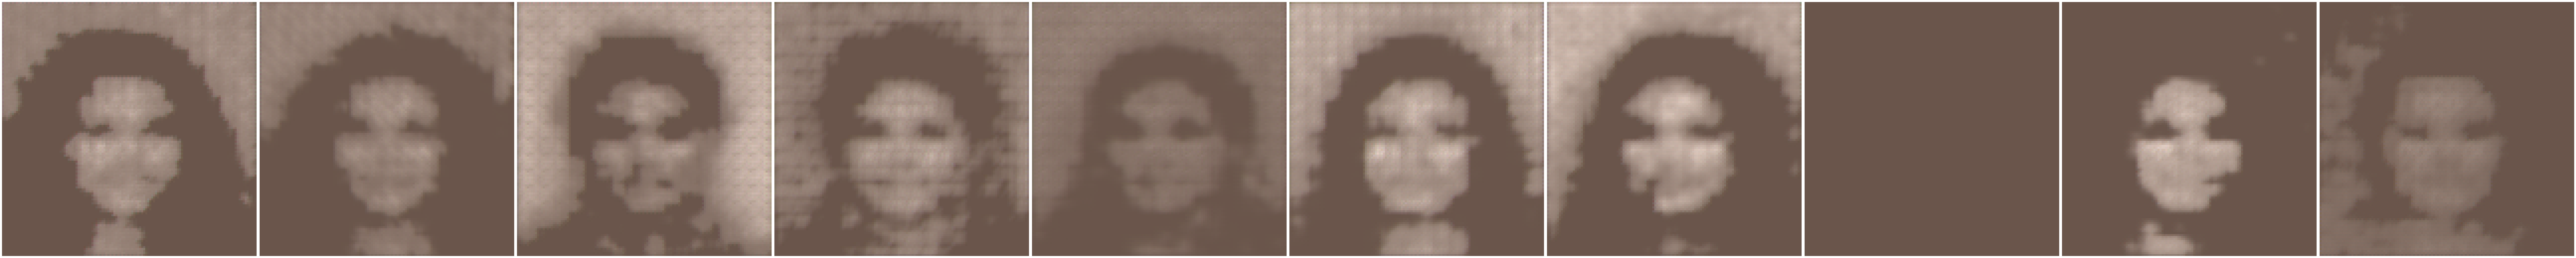

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

for i in range(10):
    img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels for clarity

plt.tight_layout()
plt.show()

In [ ]:
test_data.shape

torch.Size([64, 3, 128, 128])

In [ ]:
sample.shape

AttributeError: 'tuple' object has no attribute 'shape'

/home/user/lschulze/anaconda3/envs/lab/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


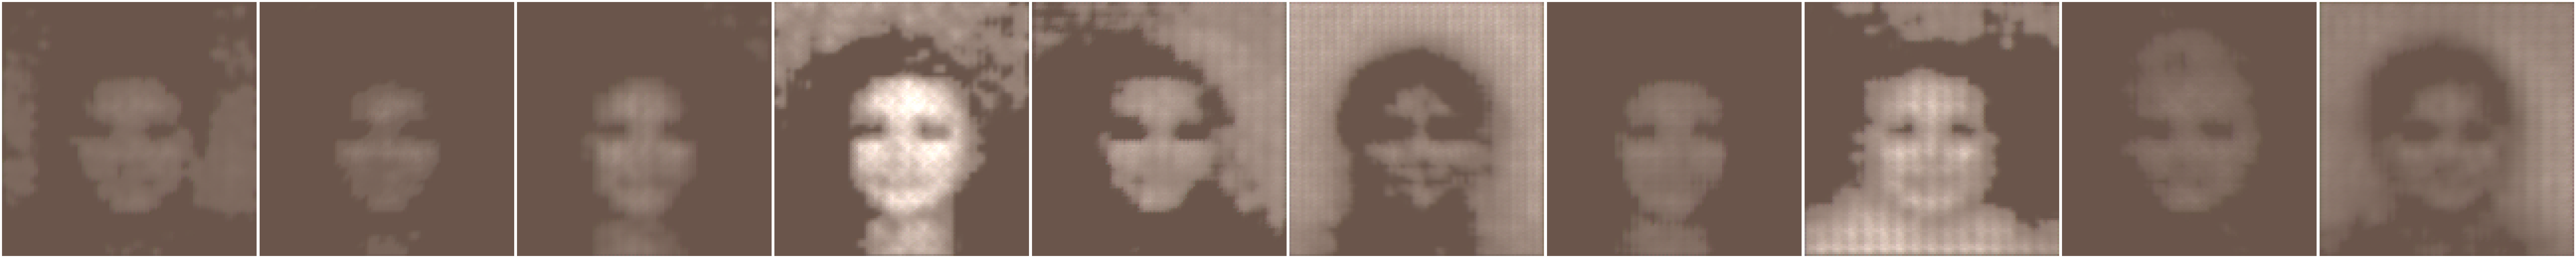

In [ ]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = cvae(test_data)

    recons = sample.view(64, 3, 128, 128).cpu()

    fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=2, transpose=False):
        super(BasicBlock, self).__init__()
        self.transpose = transpose
        output_padding = 1 if stride > 1 else 0
        self.conv1 = nn.ConvTranspose2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, \
                                        output_padding=output_padding, bias=False)
        self.conv2 = nn.ConvTranspose2d(planes, planes, kernel_size=3, stride=1, padding=1, \
                                        output_padding=0, bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.ConvTranspose2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, output_padding=output_padding, bias=False),
              #  nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) #self.bn1()
        out = self.bn2(self.conv2(out)) #self.bn2()
        out += self.shortcut(x)
        out = F.relu(out)
        return out
# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1, transpose=False):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion*planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion*planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

class Decoder(nn.Module):
    def __init__(self, block, num_blocks, latent_dim):
        super(Decoder, self).__init__()
        self.in_planes = 64*block.expansion
        self.fc2 = nn.Linear(latent_dim, 4096)
        
        self.layer1 = self._make_layer(block, 32, num_blocks[3], stride=2, transpose=True)
        self.layer2 = self._make_layer(block, 16, num_blocks[2], stride=2, transpose=True)
        self.layer3 = self._make_layer(block, 8, num_blocks[1], stride=2, transpose=True)
        self.layer4 = self._make_layer(block, 8, num_blocks[0], stride= 1, transpose=True) #this is necesarry
        self.conv1 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(3)

    def _make_layer(self, block, planes, num_blocks, stride, transpose):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in reversed(strides):
            layers.append(block(self.in_planes, planes, stride, transpose))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.fc2(x))
        out = out.view(out.size(0),64,8,8)  # reshape output of linear layer
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.layer5(out)
        out = F.relu(self.bn1(self.conv1(out))) #self.bn1()
        return out

def DecoderResNet18(latent_dim):
    return Decoder(BasicBlock, [1,1,1,1], latent_dim)

In [15]:
class ResNetVAE(nn.Module):
    def __init__(self, latent_dim = 512):
        super(ResNetVAE, self).__init__()
        
        resnet = torchvision.models.resnet18(weights='DEFAULT')
        #modules = list(convnext.children())[:-1] # delete last fc layer, so we could conviniently re-use the decoder
        #print(modules)
        # self.encoder = nn.Sequential(*modules,
        #                             nn.Flatten(),
        #                             nn.Linear(768, 8192))
        self.encoder = resnet
        
        # Note: 1000 marks the output dim of convnext tiny 
        self.mu = nn.Linear(1000, latent_dim)
        
        # Note: we learn the log variance to make training easier (allows negative values)
        self.log_var = nn.Linear(1000, latent_dim)
        
        # Decoder is re-used thanks to deleting last fc layer in the pretrained convnext encoder.
        self.decoder = DecoderResNet18(latent_dim)

        
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
        #x_hat = F.interpolate(x_hat, size=(128, 128), mode='bilinear') # fun fact, if we used different decoder architecture,
        # we would have needed to 
        return x_hat, (z, mu, log_var)

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnetvae = ResNetVAE(512)
criterion = vae_loss_function
optimizer = torch.optim.Adam(resnetvae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4, factor = 0.5, verbose = True)
resnetvae = resnetvae.to(device)

In [26]:
num_epochs = 20 #empirically, we checked that usually learning converages around these epochs

In [27]:
device

'cuda'

In [28]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=resnetvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=num_epochs, writer=None,lambda_kld=1e-4)

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04546
    Valid loss: 0.55388
       Valid loss recons: 0.28453
       Valid loss KL-D:   2693.43878


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.02435
    Valid loss: 0.02744
       Valid loss recons: 0.02271
       Valid loss KL-D:   47.34551


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.02228
    Valid loss: 0.02397
       Valid loss recons: 0.01918
       Valid loss KL-D:   47.88112


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.02118
    Valid loss: 0.02171
       Valid loss recons: 0.01695
       Valid loss KL-D:   47.58864


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.0206
    Valid loss: 0.02067
       Valid loss recons: 0.0158
       Valid loss KL-D:   48.75399


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.02035
    Valid loss: 0.02022
       Valid loss recons: 0.01523
       Valid loss KL-D:   49.94188


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.02006
    Valid loss: 0.01995
       Valid loss recons: 0.01483
       Valid loss KL-D:   51.23638


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.01983
    Valid loss: 0.02093
       Valid loss recons: 0.01586
       Valid loss KL-D:   50.70132


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.01968
    Valid loss: 0.01967
       Valid loss recons: 0.01449
       Valid loss KL-D:   51.81373


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.0197
    Valid loss: 0.01937
       Valid loss recons: 0.01404
       Valid loss KL-D:   53.32184


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.01947
    Valid loss: 0.01928
       Valid loss recons: 0.0141
       Valid loss KL-D:   51.88881
Training completed


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

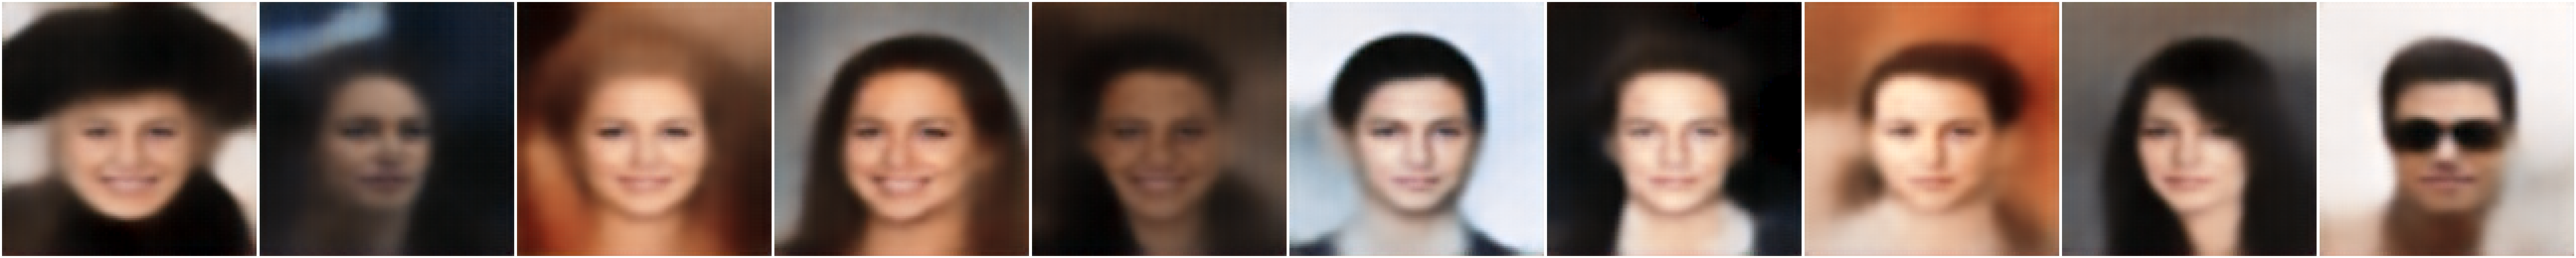

In [29]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = resnetvae(test_data)

    recons = sample.view(64, 3, 128, 128).cpu()

    fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()

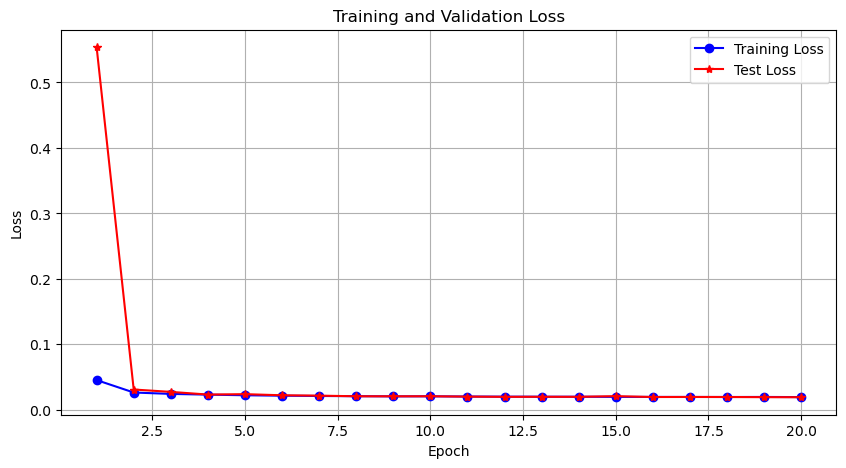

In [30]:
utils.plot_loss_epoch(train_loss, val_loss)

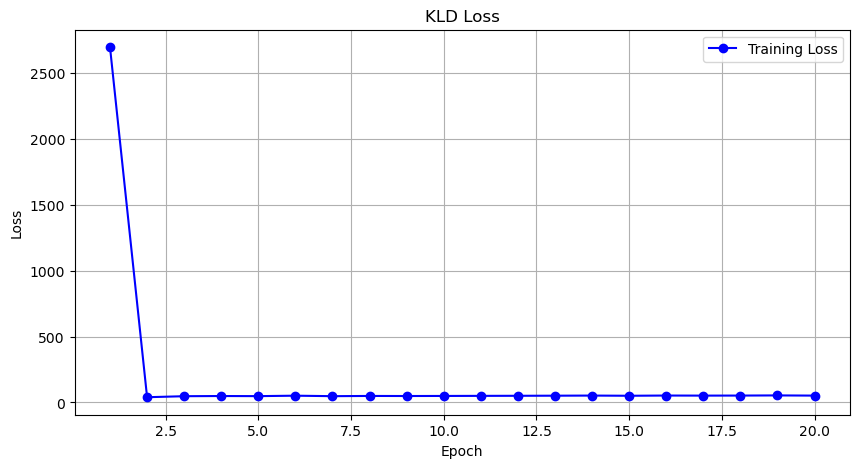

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), val_loss_kld, 'bo-', label='Training Loss')
plt.title('KLD Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnetvae = ResNetVAE(512)
criterion = vae_loss_function
optimizer = torch.optim.Adam(resnetvae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4, factor = 0.5, verbose = True)
resnetvae = resnetvae.to(device)

In [39]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=resnetvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=20, writer=None, lambda_kld=1e-03)

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.07101
    Valid loss: 3.01966
       Valid loss recons: 0.28447
       Valid loss KL-D:   2735.19191


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04359
    Valid loss: 0.04412
       Valid loss recons: 0.03491
       Valid loss KL-D:   9.21449


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04192
    Valid loss: 0.04149
       Valid loss recons: 0.03226
       Valid loss KL-D:   9.2251


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04075
    Valid loss: 0.0406
       Valid loss recons: 0.03131
       Valid loss KL-D:   9.2865


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04015
    Valid loss: 0.03977
       Valid loss recons: 0.03004
       Valid loss KL-D:   9.73023


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.04015
    Valid loss: 0.0398
       Valid loss recons: 0.02999
       Valid loss KL-D:   9.81159


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03963
    Valid loss: 0.03963
       Valid loss recons: 0.02996
       Valid loss KL-D:   9.67487


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03949
    Valid loss: 0.03911
       Valid loss recons: 0.02944
       Valid loss KL-D:   9.66664


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03931
    Valid loss: 0.03895
       Valid loss recons: 0.02918
       Valid loss KL-D:   9.76833


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03918
    Valid loss: 0.03886
       Valid loss recons: 0.02885
       Valid loss KL-D:   10.01034


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.03918
    Valid loss: 0.03886
       Valid loss recons: 0.02898
       Valid loss KL-D:   9.88358
Training completed


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

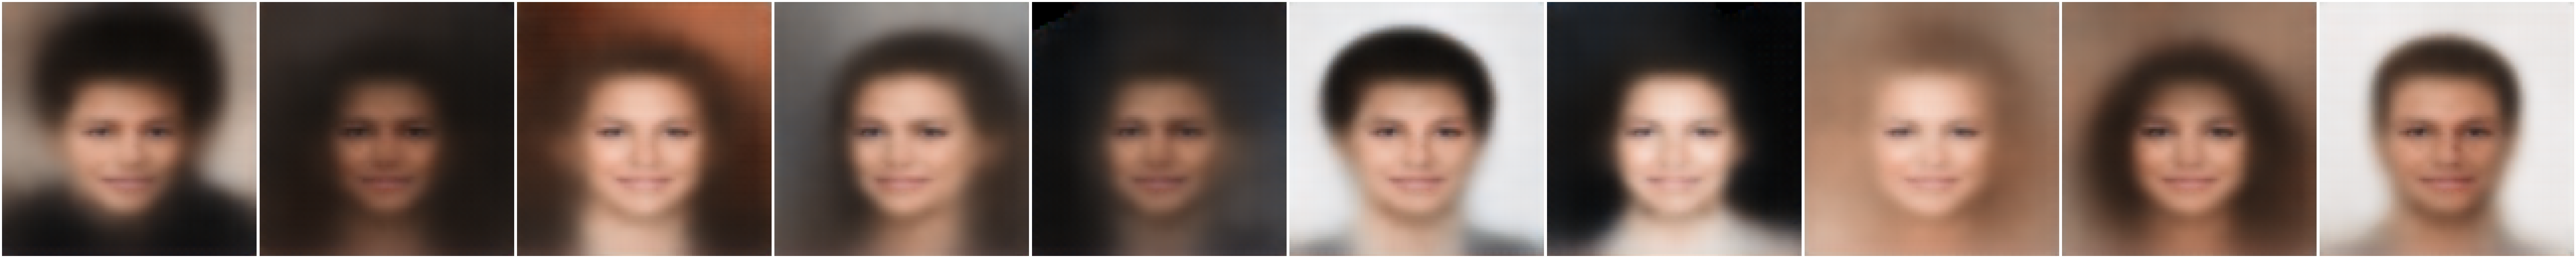

In [41]:
test_data, labels = next(iter(testloader))
test_data = test_data.to(device)

with torch.no_grad():
    sample, _ = resnetvae(test_data)

    recons = sample.view(64, 3, 128, 128).cpu()

    fig, axes = plt.subplots(1, 10, figsize=(128, 128))  # Adjust figsize as needed

    for i in range(10):
        img = recons[i].numpy().reshape(3, 128, 128).transpose(1, 2, 0)
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis labels for clarity

    plt.tight_layout()
    plt.show()

Now we increase lambda kld by a factor of 10 with regard to the starting value

In [41]:
train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
        model=cNEXTvae, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
        train_loader=trainloader, valid_loader=validloader, num_epochs=20, writer=None, lambda_kld=1e-02)

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.13076
    Valid loss: 0.29057
       Valid loss recons: 0.28452
       Valid loss KL-D:   0.6044


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.07144
    Valid loss: 0.07112
       Valid loss recons: 0.0634
       Valid loss KL-D:   0.77194


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.06624
    Valid loss: 0.06598
       Valid loss recons: 0.05687
       Valid loss KL-D:   0.91075


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

    Train loss: 0.06607
    Valid loss: 0.06543
       Valid loss recons: 0.05581
       Valid loss KL-D:   0.96172


/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

KeyboardInterrupt: 